In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score
import mlflow
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.base import TransformerMixin
import cloudpickle

##### What will happen to you if you were in a car accident?

In [2]:
# import chardet

# with open('./data/accident.CSV', 'rb') as filedata:
#     result = chardet.detect(filedata.read(10000000))
# result

In [3]:
DATASET_DIR = './data/datasets/'
data_file_name = 'person.csv'

TRAIN_PATH = f'{DATASET_DIR}/2019/{data_file_name}'
VALIDATION_PATH = f'{DATASET_DIR}/2021/{data_file_name}'
TEST_PATH = f'{DATASET_DIR}/2022/{data_file_name}'

In [4]:
df = pd.read_csv(TRAIN_PATH, encoding='Windows-1252')
df.head()

/tmp/ipykernel_1813/1528518912.py:1: DtypeWarning: Columns (15,106,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN_PATH, encoding='Windows-1252')


,STATE,STATENAME,ST_CASE,VE_FORMS,VEH_NO,PER_NO,STR_VEH,COUNTY,DAY,DAYNAME,...,WORK_INJ,WORK_INJNAME,HISPANIC,HISPANICNAME,LOCATION,LOCATIONNAME,HELM_USE,HELM_USENAME,HELM_MIS,HELM_MISNAME
0,1,Alabama,10001,2,1,1,0,81,7,7,...,8,Not Applicable (not a fatality),0,Not A Fatality (not Applicable),0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable
1,1,Alabama,10001,2,1,2,0,81,7,7,...,0,No,7,Non-Hispanic,0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable
2,1,Alabama,10001,2,2,1,0,81,7,7,...,8,Not Applicable (not a fatality),0,Not A Fatality (not Applicable),0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable
3,1,Alabama,10002,2,1,1,0,55,23,23,...,0,No,7,Non-Hispanic,0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable
4,1,Alabama,10002,2,2,1,0,55,23,23,...,8,Not Applicable (not a fatality),0,Not A Fatality (not Applicable),0,Occupant of a Motor Vehicle,20,Not Applicable,7,None Used/Not Applicable


In [5]:
df.columns.values

array(['STATE', 'STATENAME', 'ST_CASE', 'VE_FORMS', 'VEH_NO', 'PER_NO',
       'STR_VEH', 'COUNTY', 'DAY', 'DAYNAME', 'MONTH', 'MONTHNAME',
       'HOUR', 'HOURNAME', 'MINUTE', 'MINUTENAME', 'RUR_URB',
       'RUR_URBNAME', 'FUNC_SYS', 'FUNC_SYSNAME', 'HARM_EV',
       'HARM_EVNAME', 'MAN_COLL', 'MAN_COLLNAME', 'SCH_BUS',
       'SCH_BUSNAME', 'MAKE', 'MAKENAME', 'MAK_MOD', 'BODY_TYP',
       'BODY_TYPNAME', 'MOD_YEAR', 'MOD_YEARNAME', 'TOW_VEH',
       'TOW_VEHNAME', 'SPEC_USE', 'SPEC_USENAME', 'EMER_USE',
       'EMER_USENAME', 'ROLLOVER', 'ROLLOVERNAME', 'IMPACT1',
       'IMPACT1NAME', 'FIRE_EXP', 'FIRE_EXPNAME', 'AGE', 'AGENAME', 'SEX',
       'SEXNAME', 'PER_TYP', 'PER_TYPNAME', 'INJ_SEV', 'INJ_SEVNAME',
       'SEAT_POS', 'SEAT_POSNAME', 'REST_USE', 'REST_USENAME', 'REST_MIS',
       'REST_MISNAME', 'AIR_BAG', 'AIR_BAGNAME', 'EJECTION',
       'EJECTIONNAME', 'EJ_PATH', 'EJ_PATHNAME', 'EXTRICAT',
       'EXTRICATNAME', 'DRINKING', 'DRINKINGNAME', 'ALC_DET',
       'ALC_DETNAME',

In [6]:
INVESTIGATED_COLUMNS = [
    'ST_CASE', 
    'STATE',
    'STATENAME',
    'VEH_NO',
    'VE_FORMS',
    'PER_NO',
    'COUNTY',
    'DAY',
    'MONTH',
    'HOUR',
    'AGE',
    'SEX',
    'INJ_SEV',
    'INJ_SEVNAME',
    'DOA',
    'DOANAME',
    'SEAT_POS',
    'REST_USE',
]
TARGET = 'INJ_SEV'

In [7]:
# df = original_df

In [8]:
original_df = df.copy()
df = df[INVESTIGATED_COLUMNS]

#### Dropping irrelevant injury categories

The dataset user manual states these are the possible values for the injury severity field (`INJ_SEV`):

- 0 - No Apparent Injury
- 1 - Possible Injury
- 2 - Suspected Minor Injury
- 3 - Suspected Serious Injury
- 4 - Fatal Injury 
- 5 - Injured, Severity Unknown
- 6 - Died Prior to Crash
- 9 - Unknown/Not Reported 

Since we want to teach our model to predict a specific injury severity, we'll only use categories 0-4

In addition, we'll consider death as another type of injury. </br>
The user manual describes the column detailing death (`DOA`) as such:

- 0 Not Applicable 
- 7 Died at Scene
- 8 Died En Route (to a hospital)
- 9 Unknown

Again, we'll ignore cases where death is unknown and focus on categories 0,7 and 8

In [9]:
df = df[(df['INJ_SEV'] <= 4) & (df['DOA'] != 9)]

Since we want to combine the injury severity and death outcome results to one field, it's important to see what's the relationship between them

In [10]:
df[df['DOA'] >= 8].groupby('INJ_SEVNAME').size()

INJ_SEVNAME
Fatal Injury (K)    241
dtype: int64

So when a person dies, he will always be tagged as having a fatal injury. </br>
Does that imply all fatal injuries are tagged as death?

In [11]:
df[df['INJ_SEV'] == 4].groupby('DOANAME').size()

DOANAME
Died En Route       241
Died at Scene     20121
Not Applicable    15925
dtype: int64

It doesn't seem to be the case.</br>
So we'll tag an accident result as a fatal injury only when the person did not die.

We'll create a new `accident_result` field that will be our prediction target and will be a combination of both `INJ_SEV` AND `DOA`

In [12]:
def add_accident_result_columns(df, accident_result_column, accident_result_name_column):
    """
    Creates a df of accident results for the inputted df

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the raw data
    accident_result_column (str): The name of the new accident result column
    accident_result_name_column (str): The name of the new accident result label column 
    
    Returns:
    result_df (pd.DataFrame): A df containing the actual accident result 
    per the the input df's rows
    """

    # Creating a copy df containing only the columns necessary for inferring the accident result
    result_df = df.filter(regex=r'^(INJ_SEV|DOA)', axis=1).copy()
    
    # Initialize accident_result_column and accident_result_name_column based on 'INJ_SEV' and 'INJ_SEVNAME'
    result_df[accident_result_column] = result_df['INJ_SEV']
    result_df[accident_result_name_column] = result_df['INJ_SEVNAME']
    
    # If the person died, update accident_result_column and accident_result_name_column as the corrsponding death type
    mask_doa = result_df['DOA'] > 0
    result_df.loc[mask_doa, accident_result_column] = result_df.loc[mask_doa, 'DOA']
    result_df.loc[mask_doa, accident_result_name_column] = result_df.loc[mask_doa, 'DOANAME']
    
    # If the result was a fatal injury without death, 
    # we'll tag an accident result as a fatal injury only when the person did not die.
    mask_fatal = result_df[accident_result_column] == 4
    result_df.loc[mask_fatal, accident_result_name_column] = 'Fatal Injury without Death'
    
    # Clean accident_result_name_column labels
    result_df[accident_result_name_column] = result_df[accident_result_name_column].str.extract(r'^(?P<accident_result_name>[^()]+)')
    result_df[accident_result_name_column] = result_df[accident_result_name_column].str.strip()

    result_df = result_df[[accident_result_column, accident_result_name_column]]

    return result_df

def make_id_label_dict(df, id_column, label_column):
    """
    Creates a dictionary from a pandas DataFrame with IDs as keys and labels as values.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing ID and label columns.
    id_column (str): The name of the column containing the IDs.
    label_column (str): The name of the column containing the labels.
    
    Returns:
    id_label_dict (dict): A dictionary with IDs as keys and labels as values.
    """
    # Drop duplicates to ensure unique ID-label pairs
    unique_pairs = df[[id_column, label_column]].drop_duplicates()
    
    # Convert the unique pairs to a dictionary
    id_label_dict = dict(zip(unique_pairs[id_column], unique_pairs[label_column]))
    
    return id_label_dict

In [13]:
def prep_training_datasets(df):
    """
    Creates a df containing only rows our model can train on,
    a corresponding target Series for supervised learning,
    And a label dictionary for inferring the target series values

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the raw data
    including the columns necessary for creating the target column
    
    Returns:
    train_df (pd.DataFrame): A df containing only rows our model can train on
    target_df (pd.DataFrame): A pandas Series containing the target the model will learn on
    accident_result_names (dict): A dictionary containing target series textual labels
    """
    # As mentioned above, we'll train our model only on cases where 
    # the outcome of the person was known
    training_mask = (df['INJ_SEV'] <= 4) & (df['DOA'] != 9)
    
    # Create a copy of the DataFrame to avoid modifying the original
    train_df = df[training_mask].copy()

    # Names of the target column and its' corresponding textual label
    accident_result_column = 'accident_result'
    accident_result_name_column = accident_result_column + '_name'

    # Creating a df containing only the target column and its' label
    result_df = add_accident_result_columns(train_df, accident_result_column, accident_result_name_column)

    # We'll keep a dict mapping the target ordinal value to its' label
    accident_result_names = make_id_label_dict(result_df, accident_result_column, accident_result_name_column)

    # Since we have the label dict there's no need to return the label column
    target_df = result_df[accident_result_column]

    return train_df, target_df, accident_result_names

#### Dropping the labels
We'll drop the name label columns for now, since they're only really useful when we'll want to present our prediction in a user friendly way

In [14]:
CATEGORY_LABEL_COLUMNS = ['STATENAME', 'INJ_SEV', 'INJ_SEVNAME',  'DOA', 'DOANAME']
COLUMNS_FOR_MODEL = [column for column in INVESTIGATED_COLUMNS if column not in CATEGORY_LABEL_COLUMNS]

In [15]:
# df = df.drop(CATEGORY_LABEL_COLUMNS, axis=1)

### Cleaning the data

In [16]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 81521 entries, 0 to 82842
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ST_CASE      81521 non-null  int64 
 1   STATE        81521 non-null  int64 
 2   STATENAME    81521 non-null  object
 3   VEH_NO       81521 non-null  int64 
 4   VE_FORMS     81521 non-null  int64 
 5   PER_NO       81521 non-null  int64 
 6   COUNTY       81521 non-null  int64 
 7   DAY          81521 non-null  int64 
 8   MONTH        81521 non-null  int64 
 9   HOUR         81521 non-null  int64 
 10  AGE          81521 non-null  int64 
 11  SEX          81521 non-null  int64 
 12  INJ_SEV      81521 non-null  int64 
 13  INJ_SEVNAME  81521 non-null  object
 14  DOA          81521 non-null  int64 
 15  DOANAME      81521 non-null  object
 16  SEAT_POS     81521 non-null  int64 
 17  REST_USE     81521 non-null  int64 
dtypes: int64(15), object(3)
memory usage: 11.8+ MB


In [17]:
df.describe()

,ST_CASE,STATE,VEH_NO,VE_FORMS,PER_NO,COUNTY,DAY,MONTH,HOUR,AGE,SEX,INJ_SEV,DOA,SEAT_POS,REST_USE
count,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000,81521.000000
mean,270314.092025,26.953178,1.368850,1.911802,1.514579,92.566688,15.694766,6.709523,13.556397,53.061407,1.407110,2.394181,1.751389,13.000454,23.831148
std,164632.985687,16.475802,1.273783,1.950195,1.379468,96.959194,8.829369,3.373724,8.582249,110.555037,0.859091,1.690066,3.035807,11.211551,34.128658
min,10001.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,121609.000000,12.000000,1.000000,1.000000,1.000000,31.000000,8.000000,4.000000,8.000000,24.000000,1.000000,0.000000,0.000000,11.000000,3.000000
50%,260609.000000,26.000000,1.000000,2.000000,1.000000,71.000000,16.000000,7.000000,14.000000,38.000000,1.000000,3.000000,0.000000,11.000000,3.000000
75%,420469.000000,42.000000,2.000000,2.000000,2.000000,115.000000,23.000000,10.000000,19.000000,57.000000,2.000000,4.000000,0.000000,13.000000,20.000000
max,560121.000000,56.000000,58.000000,59.000000,57.000000,997.000000,31.000000,12.000000,99.000000,999.000000,9.000000,4.000000,8.000000,99.000000,99.000000


In [18]:
df[df['VEH_NO'] > 3].shape

(1711, 18)

In [19]:
df[df['VE_FORMS'] > 3].shape

(4547, 18)

In [20]:
# Here we're actually thinking of the number of cars
# as more of an ordinal variable rather than a numerical one
# Meaning accidents with 4 or more cars is a "category 4" accident
df.loc[df['VE_FORMS'] <= 3, 'VE_FORMS'] = 4

### Creating a reusable preprocessor

In [21]:
class FarsPreModelProcessor(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Keep only the specified columns
        X_transformed = X.copy()

        # Here we're actually thinking of the number of cars
        # as more of an ordinal variable rather than a numerical one
        # Meaning accidents with 4 or more cars is a "category 4" accident
        X_transformed = X_transformed.apply(lambda value: value if value <= 3 else 4)
        
        return X_transformed

In [23]:
processed_columns = ['VE_FORMS']
columns_without_processing = [col for col in COLUMNS_FOR_MODEL if col not in processed_columns]

columns_without_processing_definition = gen_features(
    columns = columns_without_processing,
    classes = [None]
)

columns_preprocessing_definition = gen_features(
    columns = ['VE_FORMS'],
     classes= [FarsPreModelProcessor]
)

dataframe_preprocessing_definition = columns_preprocessing_definition + columns_without_processing_definition

data_preparation_mapper = DataFrameMapper(
    dataframe_preprocessing_definition,
    input_df=True,
    df_out=True,
)

data_prep_steps = [('general_preprocessor', data_preparation_mapper)]

### Running models
For starters we'll try to create models that learn on the data as is.</br>
This makes sense because not having specific information about a person in a motor accident could be valuable information by itself in predicting the person's injury

### Thinking about evaluation

The evaluation metric we'll use for our model will be a weighted average of recall per class.

The more severe an injury gets, the more important it is to decrease the amount of False Negative predictions of it, since the price of an error becomes more severe. 
Therefore, it makes sense to calculate the recall score of each injury class separately and then calculate an overall weighted average that gives higher importance to more severe injuries.

For the sake of this exercise, we'll focus for now only on this metric as the only maximising metric and not take into account other satisfising factors like the predition speed of our model

In [24]:
def weighted_recall_score(true_labels: pd.Series, predicted_labels: pd.Series) -> float:
    """
    Calculate the weighted average recall score of each possible value of the true labels,
    where the weight of each group is the value of the true label.

    Args:
    - true_labels (pd.Series): Series of true labels.
    - predicted_labels (pd.Series): Series of predicted labels.

    Returns:
    - float: Weighted average recall score.
    """
    # Ensure the input series have the same length
    assert len(true_labels) == len(predicted_labels), "True and predicted labels must have the same length."
    
    # Get unique values in true labels
    unique_labels = true_labels.unique()
    
    # Initialize variables to calculate weighted recall
    total_weight = 0
    weighted_recall_sum = 0
    
    # Calculate recall for each unique label and compute weighted sum
    for label in unique_labels:
        # Create boolean masks for the current label
        true_mask = (true_labels == label)
        evaluated_true_labels = true_labels[true_mask]
        evaluated_pred_labels = predicted_labels[true_mask]
        
        # Calculate recall for the current label
        recall = recall_score(evaluated_true_labels, evaluated_pred_labels, average="micro")
        
        # Calculate the weight for the current label
        weight = int(label)
        
        # Accumulate weighted recall and total weight
        weighted_recall_sum += recall * weight
        total_weight += weight
    
    # Calculate weighted average recall
    weighted_avg_recall = weighted_recall_sum / total_weight if total_weight != 0 else 0
    
    return weighted_avg_recall

In [25]:
df1 = pd.Series([1, 1, 1, 8, 8])
df2 = pd.Series([1, 1, 1, 8, 1])

expected_result = (1*1 + 0.5*8)/(1+8)
real_result = weighted_recall_score(df1, df2)

assert expected_result == real_result

#### Trying out some simple models

In [26]:
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

#### Prep for modeling

In [27]:
def prefix_model_params(model_pipe_step_name, models):
    """
    Prefixes the model parameter keys with the given model pipeline step name.
    This prefixing is necessary for the params to be added to the sklearn.pipeline model step

    Args:
    model_pipe_step_name (str): The model pipeline step name to prefix the parameter keys with.
    models (dict): A dictionary containing model definitions and parameters.

    Returns:
    dict: A new dictionary with the prefixed parameter keys.
    """
    prefixed_models = {}
    
    for model_name, (model, params_list) in models.items():
        prefixed_params_list = []
        for params in params_list:
            prefixed_params = {f'{model_pipe_step_name}__{key}': value for key, value in params.items()}
            prefixed_params_list.append(prefixed_params)
        prefixed_models[model_name] = (model, prefixed_params_list)
    
    return prefixed_models

In [28]:
# Define the models and parameter grids to be tested
models = {
    'RandomForest': (RandomForestClassifier(), [
        {'n_estimators': 100, 'max_depth': 10},
        {'n_estimators': 200, 'max_depth': 20},
    ]),
    # # 'SVC': (SVC(probability=True), [
    # #     {'C': 1, 'kernel': 'linear'},
    # #     {'C': 1, 'kernel': 'rbf'},
    # # ]),
    # # 'LogisticRegression': (LogisticRegression(), [
    # #     {'penalty': 'l2', 'C': 1},
    # #     {'penalty': 'l2', 'C': 0.1},
    # # ]),
    'GradientBoosting': (GradientBoostingClassifier(), [
        {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
        {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3},
    ]),
    # 'XGBClassifier': (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), [
    #     {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
    #     {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3},
    # ]),
}

model_pipe_step_name = 'classifier'
models = prefix_model_params(model_pipe_step_name, models)

In [50]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [51]:
MLFLOW_EXPERIMENT_NAME = "NHTSA FARS Injury prediction"
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='gs://mlops_zoomcamp-mlflow-artifacts/artifacts/1', creation_time=1721555556438, experiment_id='1', last_update_time=1721555556438, lifecycle_stage='active', name='NHTSA FARS Injury prediction', tags={}>

In [31]:
val_df = pd.read_csv(VALIDATION_PATH, encoding='Windows-1252')

/tmp/ipykernel_1813/506465049.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(VALIDATION_PATH, encoding='Windows-1252')


In [32]:
# Seperating the target column
train_df, train_target_df, train_label_for_target = prep_training_datasets(df)
val_df, val_target_df, val_label_for_target = prep_training_datasets(val_df)

In [33]:
assert train_label_for_target == val_label_for_target

In [34]:
preprocessing_params = {
    'VE_FORMS_outlier_strategy': '>=4 becomes category 4',
}

artifacts = [
    { 
        'type': 'dict',
        'object': train_label_for_target,
        'file_name': 'NHTSA_FARS_labels_for_target.json',
    },
    # { 
    #     'type': 'file',
    #     'local_path': label_for_target_file,
    #     'artifact_path': 'label_for_target',
    # },
]

#### MODEL

In [35]:
# Define a function to log the model and metrics to mlflow
def log_pipeline_with_mlflow(model_name, model, model_params, preprocess_params, artifacts, X_train, X_val, y_train, y_val, is_validation_set_test = False):
    with mlflow.start_run():
        # Log the model type as a tag for easy filtering
        mlflow.set_tag(key = 'model_name', value = model_name)

        # Log preprocessing parameters
        mlflow.log_params(preprocess_params)
        
        # Log model parameters
        mlflow.log_params(model_params)

        # Set the parameters
        model.set_params(**model_params)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict and calculate the wighted recall score for the training set
        y_train_pred = model.predict(X_train)
        train_weighted_recall = weighted_recall_score(y_train, y_train_pred)
        mlflow.log_metric('train_weighted_recall', train_weighted_recall)

        # Predict and calculate the wighted recall score for the validation set
        y_val_pred = model.predict(X_val)
        val_weighted_recall = weighted_recall_score(y_val, y_val_pred)

        if not is_validation_set_test:
            mlflow.log_metric('val_weighted_recall', val_weighted_recall)
        else:
            mlflow.log_metric('test_weighted_recall', val_weighted_recall)
        
        # Log the model
        if model_name == "XGBClassifier":
            mlflow.xgboost.log_model(model, model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)

        # Log the artifacts
        for artifact in artifacts:
            if artifact['type'] == 'dict':
                mlflow.log_dict(dictionary = artifact['object'], artifact_file = artifact['file_name'])
            elif artifact['type'] == 'file':
                mlflow.log_artifact(local_path = artifact['local_path'], artifact_path = artifact['artifact_path'])

In [36]:
# Train and log each model using a pipeline
def train_and_log_pipelines(models, data_prep_steps, preprocessing_params, artifacts, X_train, X_val, y_train, y_val, is_validation_set_test = False):
    for model_name, (model, model_params_combinations) in models.items():
        for model_params_combination in model_params_combinations:
            pipeline_steps = data_prep_steps.copy()
            pipeline_steps.append((model_pipe_step_name, model))
            pipeline = Pipeline(pipeline_steps)

            log_pipeline_with_mlflow(model_name = model_name,
                                    model = pipeline,
                                    model_params = model_params_combination,
                                    preprocess_params = preprocessing_params,
                                    artifacts = artifacts,
                                    X_train = X_train,
                                    X_val = X_val,
                                    y_train = y_train,
                                    y_val = y_val,
                                    is_validation_set_test=is_validation_set_test)

In [ ]:
train_and_log_pipelines(
    models = models,
    data_prep_steps = data_prep_steps,
    preprocessing_params = preprocessing_params,
    artifacts = artifacts,
    X_train = train_df,
    X_val = val_df,
    y_train = train_target_df,
    y_val = val_target_df,
    is_validation_set_test = False)

## Productionizing the best model

The results for our models are honestly pretty bad. </br>
But since the purpose of our project is productionizing our model, this will suffice for now 

In [37]:
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
import re

In [38]:
def filter_dict_by_regex(input_dict, pattern):
    """
    Filters a dictionary by keys that match a given regex pattern.

    Args:
    input_dict (dict): The input dictionary to be filtered.
    pattern (str): The regex pattern to match the keys.

    Returns:
    tuple: Two dictionaries, the first with key-value pairs where the keys match the regex pattern,
           and the second with key-value pairs where the keys do not match the regex pattern.
    """
    regex = re.compile(pattern)
    matching_dict = {}
    non_matching_dict = {}
    
    for key, value in input_dict.items():
        if regex.match(key):
            matching_dict[key] = value
        else:
            non_matching_dict[key] = value
    
    return matching_dict, non_matching_dict

In [ ]:
get_best_n_runs(experiment_name, metric_name, n=3, is_higher_better = True)

In [61]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from inspect import signature

def get_best_n_runs(experiment_name, metric_name, n=3, is_higher_better = True):
    """
    Retrieve the top n runs based on a specified metric.

    Args:
    experiment_name (str): The name of the MLflow experiment.
    metric_name (str): The name of the metric to sort by.
    n (int): The number of top runs to retrieve.

    Returns:
    List of run info of the top n runs.
    """
    client = mlflow.tracking.MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    sort_order = 'DESC' if is_higher_better else 'ASC'

    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=[f"metrics.{metric_name} {sort_order}"],
        max_results=n,
        filter_string="attributes.status = 'FINISHED'"
    )
    return runs

def load_pipeline_from_run(run_id, model_name):
    """
    Load a pipeline artifact from an MLflow run.

    Args:
    run_id (str): The run ID to load the pipeline from.
    model_name (str): The name of the pipeline artifact.

    Returns:
    The loaded pipeline.
    """
    model_uri = f"runs:/{run_id}/{model_name}"

    if model_name == "XGBClassifier":
        pipeline = mlflow.xgboost.load_model(model_uri)
    else:
        pipeline = mlflow.sklearn.load_model(model_uri)
    
    return pipeline

def recreate_dataframe_mapper(original_mapper):
    """
    Recreate a DataFrameMapper with the same parameters and settings.

    Args:
    original_mapper (DataFrameMapper): The original DataFrameMapper.

    Returns:
    The new DataFrameMapper with the same parameters and settings.
    """
    return DataFrameMapper(
        original_mapper.features,
        input_df=original_mapper.input_df,
        df_out=original_mapper.df_out
    )

def recreate_pipeline_steps(original_pipeline):
    """
    Recreate the pipeline steps with untrained instances.

    Args:
    original_pipeline (Pipeline): The original pipeline.

    Returns:
    A list of steps with untrained instances.
    """
    new_steps = []
    for name, step in original_pipeline.steps:
        if isinstance(step, DataFrameMapper):
            new_step = recreate_dataframe_mapper(step)
        else:
            new_step = step.__class__()
        new_steps.append((name, new_step))
    return new_steps

def create_fresh_pipeline(original_pipeline):
    """
    Create a new pipeline with the same steps and given parameters.

    Args:
    original_pipeline (Pipeline): The original pipeline.

    Returns:
    A new pipeline with the same exact steps.
    """
    steps = recreate_pipeline_steps(original_pipeline)
    new_pipeline = Pipeline(steps)
    return new_pipeline

def infer_param_types(pipeline):
    """
    Infer parameter types based on the model class's default parameter values.
    """
    original_params = pipeline.get_params()
    param_types = {key: type(value) for key, value in original_params.items()}
    return param_types

def convert_params_to_original_types(params, pipeline):
    """
    Convert parameter values to their original types based on the model class.
    """
    param_types = infer_param_types(pipeline)
    converted_params = {}
    
    for param_name, value in params.items():
        # param_name = key.split("__")[-1]
        if param_name in param_types:
            param_type = param_types[param_name]
            converted_params[param_name] = param_type(value)
        else:
            converted_params[param_name] = value
    return converted_params


def retrain_top_pipelines(experiment_name, metric_name, top_n, is_higher_better, X_train, y_train, X_test, y_test, artifacts):
    """
    Retrain the top n pipelines based on a specified metric with new data.

    Args:
    experiment_name (str): The name of the MLflow experiment.
    metric_name (str): The name of the metric to sort by.
    top_n (int): The number of top pipelines to retrain.
    X_train (pd.DataFrame): The new training features.
    y_train (pd.Series): The new training labels.
    X_test (pd.DataFrame): The test set for comparing our models.
    y_test (pd.Series): The test set labels.

    Returns:
    A list of retrained pipelines.
    """
    top_runs = get_best_n_runs(experiment_name, metric_name, top_n, is_higher_better = is_higher_better)

    for run in top_runs:
        run_id = run.info.run_id
        model_name = run.data.tags['model_name']
        original_pipeline = load_pipeline_from_run(run_id, model_name)
        
        # Create a new pipeline with untrained steps and parameters
        new_pipeline = create_fresh_pipeline(original_pipeline)

        # Retrieve the model parameters
        pipeline_params, non_pipeline_params = filter_dict_by_regex(run.data.params, f'^\w+__')
        
        # Convert model params to their original types
        pipeline_params = convert_params_to_original_types(pipeline_params, original_pipeline)
        
        # Retrain the new pipeline with the new data
        log_pipeline_with_mlflow(model_name = model_name,
                        model = new_pipeline,
                        model_params = pipeline_params,
                        preprocess_params = non_pipeline_params,
                        artifacts = artifacts,
                        X_train = X_train,
                        X_val = X_test,
                        y_train = y_train,
                        y_val = y_test,
                        is_validation_set_test=True,)


In [ ]:
# Retraining top models on train+val single dataset
train_df = pd.read_csv(TRAIN_PATH, encoding='Windows-1252')
val_df = pd.read_csv(VALIDATION_PATH, encoding='Windows-1252')
test_df = pd.read_csv(TEST_PATH, encoding='Windows-1252')

# We'll train the best models on the training and validation data
final_train_df = pd.concat([train_df, val_df], ignore_index=True)

# Seperating the target column    
final_train_df, final_train_target_df, final_train_label_for_target = prep_training_datasets(final_train_df)
test_df, test_target_df, test_label_for_target = prep_training_datasets(test_df)

experiment_name = MLFLOW_EXPERIMENT_NAME
metric_name = "val_weighted_recall"
artifacts = [
    { 
        'type': 'dict',
        'object': final_train_label_for_target,
        'file_name': 'NHTSA_FARS_labels_for_target.json',
    },
]

retrain_top_pipelines(experiment_name = experiment_name,
                      metric_name = metric_name,
                      top_n=3,
                      is_higher_better = True,
                      X_train = final_train_df,
                      y_train = final_train_target_df,
                      X_test = test_df,
                      y_test = test_target_df,
                      artifacts = artifacts,)

In [64]:
# Select the model with the highest test weighted_recall
client = MlflowClient()

# Retrieve the top_n model runs and log the models
experiment = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)

best_run = client.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.test_weighted_recall DESC"],
    filter_string="attributes.status = 'FINISHED'"
)[0]

# Register the best model
registered_model_name = 'starter_notebook_model'

model_version = mlflow.register_model(
    model_uri=f"runs:/{best_run.info.run_id}/models",
    name=registered_model_name
)

# Add tags to the registered model
client.set_registered_model_tag(registered_model_name, "task", "classification")

accident_result_unique_values_count = len(final_train_label_for_target)
client.set_registered_model_tag(registered_model_name, "accident_result_unique_values_count", accident_result_unique_values_count)

# Add Champion alias since it's the only model
client.set_registered_model_alias(registered_model_name, "Champion", model_version.version)

Successfully registered model 'starter_notebook_model'.
2024/08/03 18:18:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: starter_notebook_model, version 1
Created version '1' of model 'starter_notebook_model'.


In [66]:
import mlflow.pyfunc

alias = "Champion"
model_path = 'gs://mlops_zoomcamp-mlflow-artifacts/artifacts/1/309206cac0ca4043bb9b42a6bd5aded0/artifacts/GradientBoosting'
champion_model = mlflow.pyfunc.load_model(model_path)

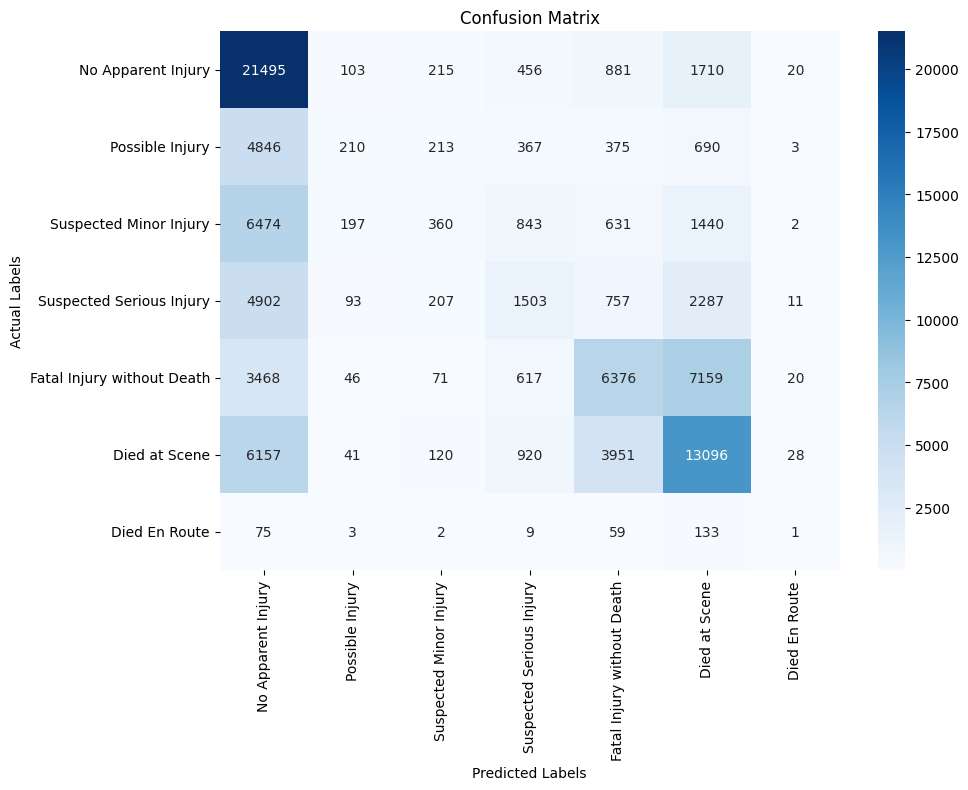

In [85]:
import numpy as np
from sklearn import metrics

def plot_confusion_matrix(model, test_df, test_true_labels, textual_labels):
    test_predictions = model.predict(test_df)

    translated_test_target_df = test_true_labels.map(textual_labels)

    # Create a vectorized function that applies the dictionary mapping
    vectorized_map = np.vectorize(textual_labels.get)

    # Translate the numbers in the array to their corresponding strings using the vectorized function
    translated_test_predictions = vectorized_map(test_predictions)

    # Define the order of labels according to their numerical values
    label_order = [textual_labels[key] for key in sorted(textual_labels.keys())]

    confusion_matrix = metrics.confusion_matrix(translated_test_target_df, translated_test_predictions, labels=label_order)


    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_order, 
                yticklabels=label_order)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(champion_model, test_df, test_target_df, test_label_for_target)